In [4]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.datasets import load_iris 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

In [5]:
from micrograd.engine import Value 
from micrograd.nn import Neuron, Layer, MLP 

In [6]:
np.random.seed(1337)
random.seed(1337)

In [7]:
# Dataset \
iris = load_iris()
X = iris.data[:, :2]
y = iris.target

In [8]:
y_binary = np.where(y == 0, 1, -1)

In [9]:
# Scale features 
y_binary = np.where(y == 0, 1, -1)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)


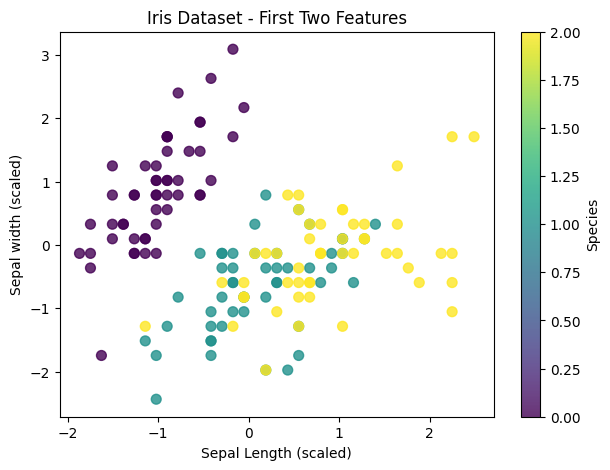

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Species')
plt.title('Iris Dataset - First Two Features')
plt.xlabel('Sepal Length (scaled)')
plt.ylabel('Sepal width (scaled)')
plt.show()

In [14]:
model = MLP(2, [8, 4, 1])
print(model)
print("Number of parameters: ", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8)], Layer of [LinearNeuron(4)]]
Number of parameters:  65


In [16]:

def loss_function(X_data, y_data, batch_size=None):
    # Mini-batch sampling
    if batch_size is None:
        Xb, yb = X_data, y_data
    else:
        ri = np.random.permutation(X_data.shape[0])[:batch_size]
        Xb, yb = X_data[ri], y_data[ri]
    
    # Convert inputs to Value objects
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward pass
    scores = list(map(model, inputs))
    
    # Hinge loss (SVM loss)
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization with custom strength
    alpha = 5e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # Calculate accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [17]:
# initial loss and accuracy 
total_loss, acc = loss_function(X_train, y_train)
print(f'Inital loss: {total_loss.data}, accuracy: {acc*100:.2f}%')


Inital loss: 0.9935798326792633, accuracy: 33.33%


In [18]:
epochs = 150 
batch_size = 32 
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    total_loss, acc = loss_function(X_train, y_train, batch_size=batch_size)
    train_losses.append(total_loss.data)
    train_accuracies.append(acc)

    model.zero_grad()
    total_loss.backward()

    learning_rate = 0.5 * (1 + np.cos(np.pi * epoch / epochs))

    for p in model.parameters():
        p.data -= learning_rate * p.grad 

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss.data:.6f} | Accuracy: {acc*100:.2f}%")
        

Epoch 0 | Loss: 0.981339 | Accuracy: 34.38%
Epoch 10 | Loss: 0.026261 | Accuracy: 100.00%
Epoch 20 | Loss: 0.022425 | Accuracy: 100.00%
Epoch 30 | Loss: 0.009868 | Accuracy: 100.00%
Epoch 40 | Loss: 0.039114 | Accuracy: 100.00%
Epoch 50 | Loss: 0.071362 | Accuracy: 96.88%
Epoch 60 | Loss: 0.010201 | Accuracy: 100.00%
Epoch 70 | Loss: 0.010174 | Accuracy: 100.00%
Epoch 80 | Loss: 0.060019 | Accuracy: 96.88%
Epoch 90 | Loss: 0.010375 | Accuracy: 100.00%
Epoch 100 | Loss: 0.033343 | Accuracy: 100.00%
Epoch 110 | Loss: 0.010435 | Accuracy: 100.00%
Epoch 120 | Loss: 0.016956 | Accuracy: 100.00%
Epoch 130 | Loss: 0.010488 | Accuracy: 100.00%
Epoch 140 | Loss: 0.010487 | Accuracy: 100.00%


In [19]:
final_loss, final_acc = loss_function(X_test, y_test)
print(f'\nTest accuracy: {final_acc*100:.2f}%')


Test accuracy: 100.00%


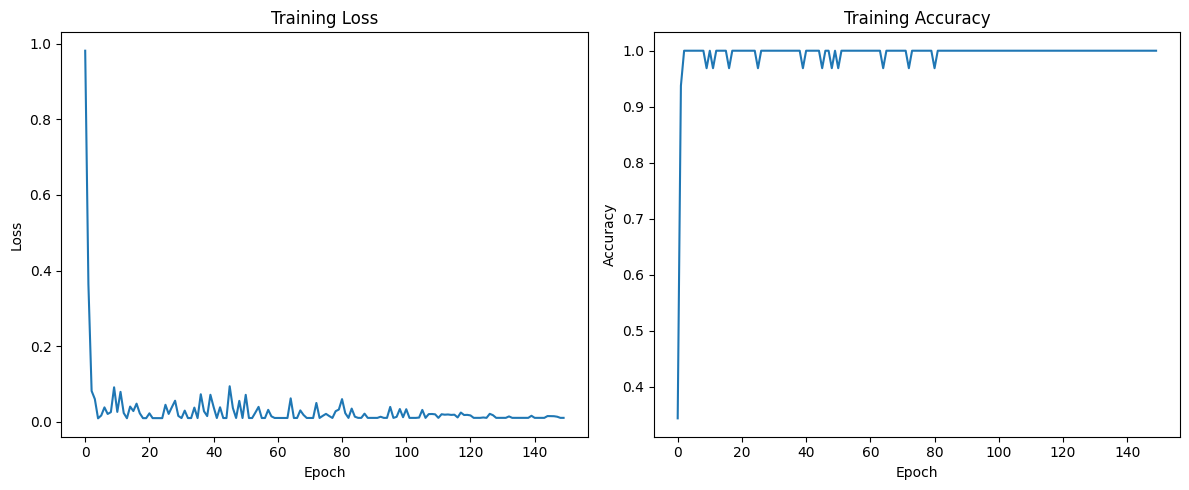

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

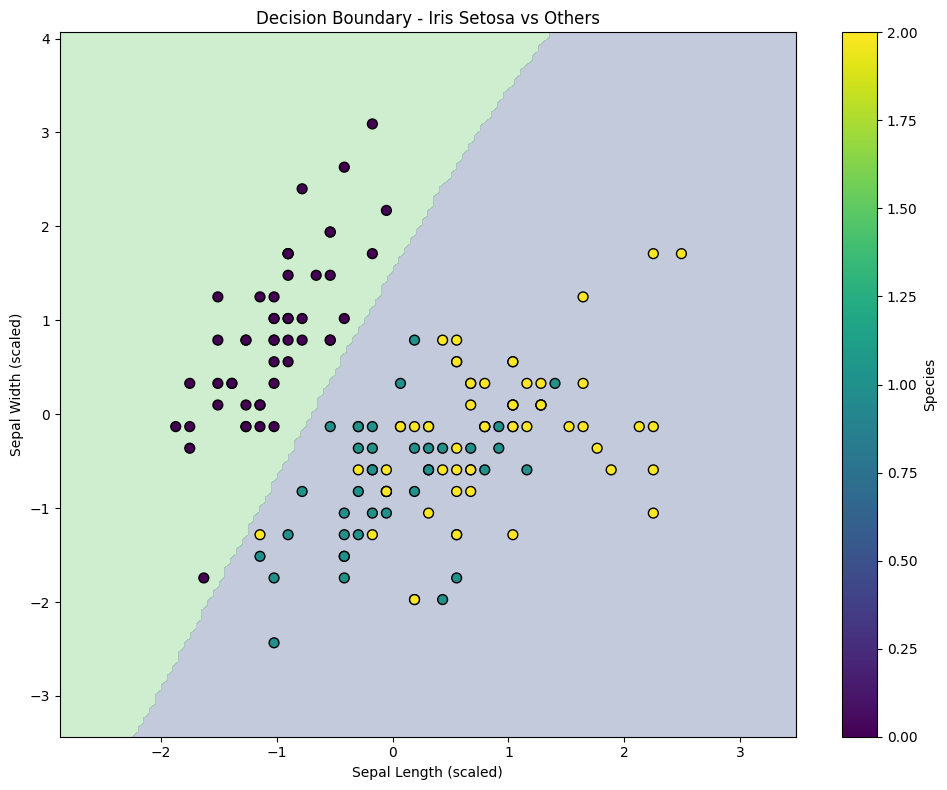

In [22]:
## Visualize decision boundary 

h = 0.05 
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=50, edgecolors='k')
plt.title('Decision Boundary - Iris Setosa vs Others')
plt.xlabel('Sepal Length (scaled)')
plt.ylabel('Sepal Width (scaled)')
plt.colorbar(label='Species')
plt.tight_layout()
plt.show()